<a href="https://colab.research.google.com/github/oracky/Corona-virus-Europe-analysis/blob/master/Corona_virus_in_Europe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [0]:
from typing import List
from functools import reduce
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import datetime
import os
import csv

# Functions for getting data for analysis

In [0]:
def get_europe_countries():
    url = f"https://raw.githubusercontent.com/oracky/Corona-virus-Europe-analysis"\
          f"/master/countries2.csv"
    countries = pd.read_csv(url, error_bad_lines=False)
    europe_countries = countries.loc[countries["Continent"]=="Europe"]
    return europe_countries["Country/Region"].values.tolist()

In [0]:
def get_country_gdp():
    """
    Important!
    Returns list of only EUROPEAN countries GDP in 2019 (in billion USD)
    """
    url = f"https://raw.githubusercontent.com/oracky/Corona-virus-Europe-analysis"\
          f"/master/gdp-europe-2019.csv"
    gdp = pd.read_csv(url, error_bad_lines=False)
    return gdp

In [0]:
def get_confirmed_cases():
    url = f"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"\
          f"csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    return pd.read_csv(url, error_bad_lines=False)

In [0]:
def get_confirmed_deaths():
    url = f"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"\
          f"csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
    return pd.read_csv(url, error_bad_lines=False)

In [0]:
def get_confirmed_recoveries():
    url = f"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"\
          f"csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
    return pd.read_csv(url, error_bad_lines=False)

In [0]:
def get_death_ratio(df_deaths, df_cases):
    """
    :param df_deaths: DataFrame with confirmed deaths
    :param df_cases: DataFrame with confirmed cases
    """
    return df_deaths['Cases'][-1] / df_cases['Cases'][-1]

# Filter results

In [0]:
def filter_overseas(countries):
    """
    :param countries: DataFrame with virus cases
    """
    return countries[countries["Province/State"].isnull()]

In [0]:
def select_only_europe(countries):
    """
    :param countries: DataFrame with virus cases
    """
    countries = filter_overseas(countries)
    return countries[countries["Country/Region"].isin(get_europe_countries())]
  

In [0]:
def clean_data(df_raw):
    df_cleaned=df_raw.melt(id_vars=['Province/State','Country/Region','Lat','Long'],value_name='Cases',var_name='Date')
    df_cleaned=df_cleaned.set_index(['Country/Region','Province/State','Date'])
    return df_cleaned

In [0]:
def drop_unnecesary_cols(df, l_list=None): 
    """
    :param l_list: contains labels of collumns, must be str type
    :param df: DataFrame with cleaned data (after clean_Data func)
    """
    if list is not None:
      for col in l_list:
        df.drop(col, axis=1, inplace=True)
      



# Plotting nominal GDP for European Countries

In [11]:

df = get_country_gdp()
formated_gdf = df.groupby(["Country"]).max()
formated_gdf =  formated_gdf.reset_index()
formated_gdf['size'] = formated_gdf["GDP2019"].pow(0.5)


fig = px.choropleth(formated_gdf, locations='Country',
                     locationmode='country names', color='GDP2019',
                     hover_name='Country',
                     range_color= [0, max(formated_gdf['GDP2019'])],
                     #size='size',
                     scope='europe',
                     projection='natural earth'
                     )
fig.update_layout(
    title={
        'text':'Nominal GDP for European countries in billion USD',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})


fig.show()


# Finding countries with top3 and low3 GDP

In [12]:
conf_cases = get_confirmed_cases()
deaths = get_confirmed_deaths()
europe_countries_cases = select_only_europe(conf_cases)
europe_deaths = select_only_europe(deaths)

gdp = get_country_gdp()
gdp = gdp.sort_values(by='GDP2019')
ctr = gdp.head(3)
low3 = gdp.tail(3)
ctr = ctr.append(low3,ignore_index=True)
intr_ctr = ctr['Country'].values.tolist()

europe_countries_cases = europe_countries_cases[europe_countries_cases
                                              ['Country/Region'].isin(intr_ctr)]
europe_deaths = europe_deaths[europe_deaths['Country/Region'].isin(intr_ctr)]

europe_countries_cases


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267
116,NaN,France,46.2276,2.2137,0,0,2,3,3,3,4,5,5,5,6,6,6,6,6,6,6,11,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,12,14,18,38,57,100,130,191,204,285,377,653,949,1126,1209,1784,2281,2281,3661,4469,4499,6633,7652,9043,10871,12612,14282,16018,19856,22304,25233,29155,32964
120,NaN,Germany,51.0000,9.0000,0,0,0,0,0,1,4,4,4,5,8,10,12,12,12,12,13,13,14,14,16,16,16,16,16,16,16,16,16,16,16,16,16,16,17,27,46,48,79,130,159,196,262,482,670,799,1040,1176,1457,1908,2078,3675,4585,5795,7272,9257,12327,15320,19848,22213,24873,29056,32986,37323,43938,50871
162,NaN,Montenegro,42.5000,19.3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,3,14,14,21,27,47,52,69,82
191,NaN,San Marino,43.9424,12.4578,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,8,10,16,21,21,23,36,36,51,62,69,80,80,101,109,109,119,119,144,144,175,187,187,208,208,223
223,NaN,United Kingdom,55.3781,-3.4360,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,3,3,3,8,8,9,9,9,9,9,9,9,9,9,9,9,9,13,13,13,15,20,23,36,40,51,85,115,163,206,273,321,382,456,456,798,1140,1140,1543,1950,2626,2689,3983,5018,5683,6650,8077,9529,11658,14543


# Comparison between richer and poorer european countries


## Confirmed cases, deaths and spreading of SARS-CoV-2019 (last two weeks)

In [0]:
# getting wanted countries data frames
andorra = europe_countries_cases.loc[europe_countries_cases
                                     ["Country/Region"]=="Andorra"]
andorra_cases = clean_data(andorra)
france = europe_countries_cases.loc[europe_countries_cases
                                     ["Country/Region"]=="France"]
france_cases = clean_data(france)
germany = europe_countries_cases.loc[europe_countries_cases
                                     ["Country/Region"]=="Germany"]
germany_cases = clean_data(germany)
montenegro = europe_countries_cases.loc[europe_countries_cases
                                     ["Country/Region"]=="Montenegro"]
montenegro_cases = clean_data(montenegro)
sanmarino = europe_countries_cases.loc[europe_countries_cases
                                     ["Country/Region"]=="San Marino"]
sanmarino_cases = clean_data(sanmarino)
uk = europe_countries_cases.loc[europe_countries_cases
                                     ["Country/Region"]=="United Kingdom"]
uk_cases = clean_data(uk)

In [0]:
# getting wanted countries data frames
andorra_d = europe_deaths.loc[europe_deaths
                                     ["Country/Region"]=="Andorra"]
andorra_deaths = clean_data(andorra_d)
france_d = europe_deaths.loc[europe_deaths
                                     ["Country/Region"]=="France"]
france_deaths = clean_data(france_d)
germany_d = europe_deaths.loc[europe_deaths
                                     ["Country/Region"]=="Germany"]
germany_deaths = clean_data(germany_d)
montenegro_d = europe_deaths.loc[europe_deaths
                                     ["Country/Region"]=="Montenegro"]
montenegro_deaths = clean_data(montenegro_d)
sanmarino_d = europe_deaths.loc[europe_deaths
                                     ["Country/Region"]=="San Marino"]
sanmarino_deaths = clean_data(sanmarino_d)
uk_d = europe_deaths.loc[europe_deaths
                                     ["Country/Region"]=="United Kingdom"]
uk_deaths = clean_data(uk_d)

In [0]:
df_list = [andorra_cases,france_cases,germany_cases,montenegro_cases,
           sanmarino_cases,uk_cases]

# reduced data frame
df_all = reduce(lambda left,right: pd.merge(left,right,on='Date'), df_list)

# droping columns with latitude and longitude
drop_unnecesary_cols(df_all,['Lat_x','Lat_y','Long_x','Long_y'])

df_all.columns = ['Andorra', 'France', 'Germany', 'Montenegro', 'San Marino',
                  'United Kingdom']

In [0]:
df_list_d = [andorra_deaths,france_deaths,germany_deaths,montenegro_deaths,
           sanmarino_deaths,uk_deaths]

# reduced data frame
df_all_d = reduce(lambda left,right: pd.merge(left,right,on='Date'), df_list_d)

# droping columns with latitude and longitude
drop_unnecesary_cols(df_all_d,['Lat_x','Lat_y','Long_x','Long_y'])

df_all_d.columns = ['Andorra', 'France', 'Germany', 'Montenegro', 'San Marino',
                    'United Kingdom']

### Charts with confirmed cases

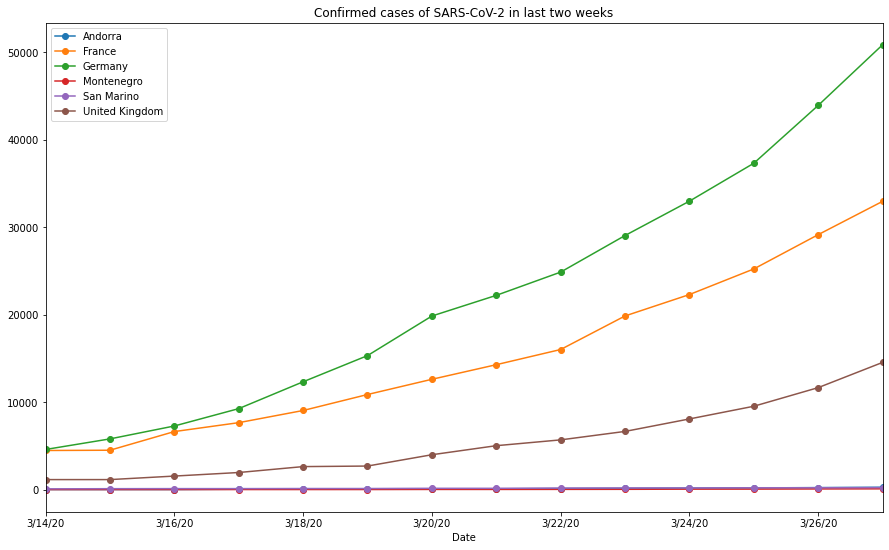

In [87]:
df_all.tail(14).plot(y=['Andorra', 'France', 'Germany', 'Montenegro', 
                        'San Marino', 'United Kingdom'],
                        figsize=(15,9), marker='o', 
                        title='Confirmed cases of SARS-CoV-2 in last two weeks',
                     logy=False)

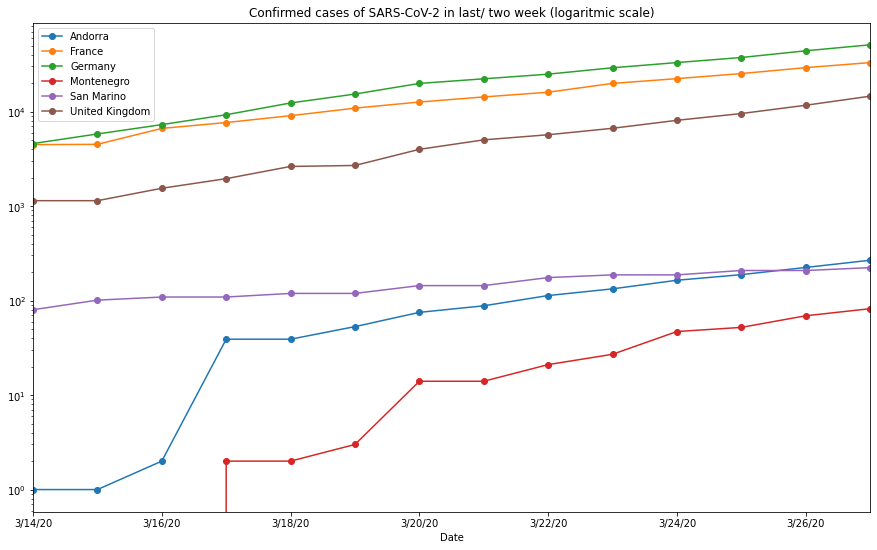

In [88]:
df_all.tail(14).plot(y=['Andorra', 'France', 'Germany', 'Montenegro', 
                        'San Marino', 'United Kingdom'],
                        figsize=(15,9), marker='o',
                        title=f'Confirmed cases of SARS-CoV-2 in last'\
                        f'/ two week (logaritmic scale)', logy=True)

### Chart with number of deaths caused by SARS-CoV-2019 (last two weeks)

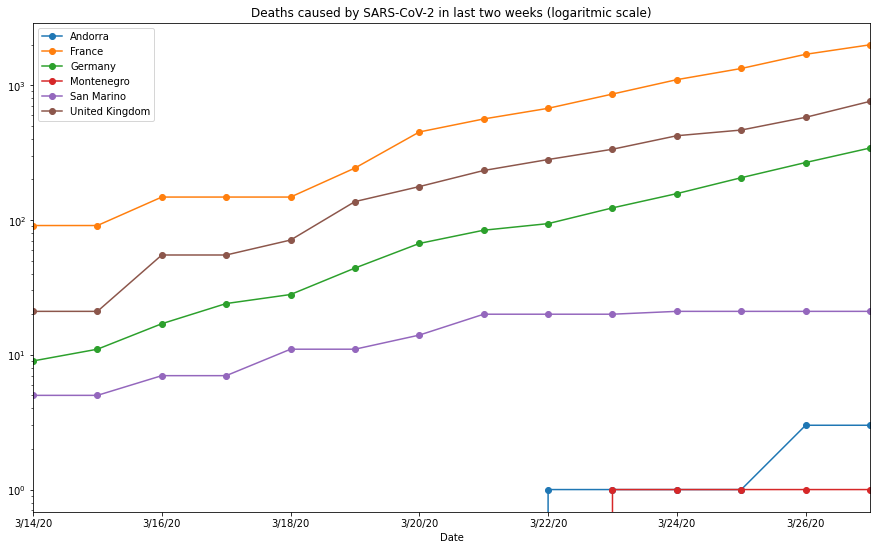

In [89]:
df_all_d.tail(14).plot(y=['Andorra', 'France', 'Germany', 'Montenegro', 
                        'San Marino', 'United Kingdom'],
                        figsize=(15,9), marker='o', 
      title='Deaths caused by SARS-CoV-2 in last two weeks (logaritmic scale)',
      logy=True)

# Death ratio relation with GDP

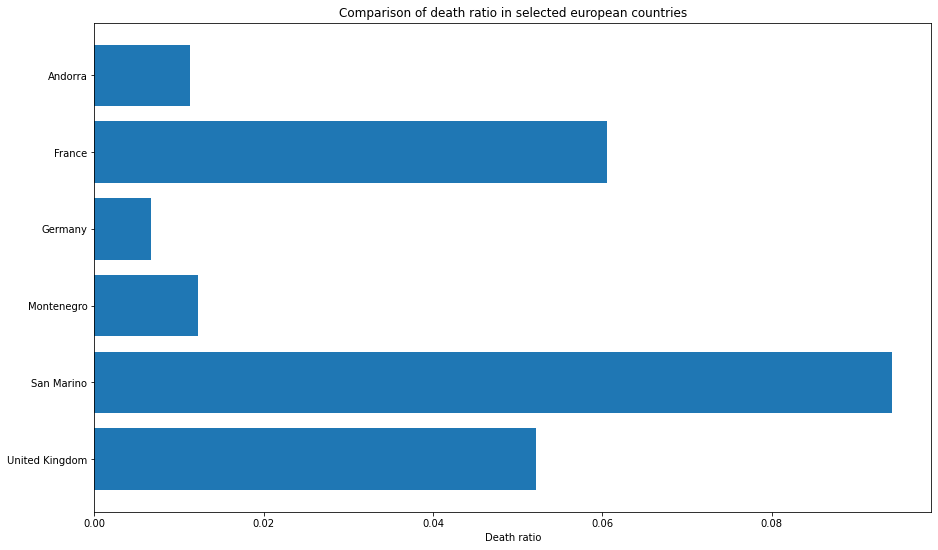

1399

In [92]:
country_names_list = europe_countries_cases['Country/Region'].values.tolist()
ratio_list = []

for i, country in enumerate(df_list):
   ratio_list.append(df_list_d[i]['Cases'][-1]/country['Cases'][-1])


fig, ax = plt.subplots(figsize=(15, 9))

# Example data
countries = country_names_list
y_pos = np.arange(len(countries))
death_ratio = ratio_list

ax.barh(y_pos, death_ratio, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(countries)
ax.invert_yaxis()  
ax.set_xlabel('Death ratio')
ax.set_title('Comparison of death ratio in selected european countries')

plt.show()

df_list[0]['Cases'].sum()